# Prédictions du cours euros-dollars

Ce projet permet de prédire a 5 jours le cours de l'euros dollars grâce au machine learning.

In [ ]:
pip install yfinance

In [ ]:
pip install livelossplot

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import RootMeanSquaredError, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, InputLayer, Dense
from livelossplot import PlotLossesKeras

In [95]:
data = yf.download("EURUSD=X", start="2015-01-01", progress=False)

In [96]:
data_close = data['Close']

In [97]:
time = data.index

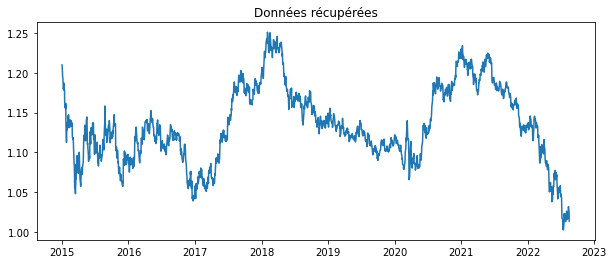

In [98]:
plt.figure(figsize=(10,4))
plt.plot(time, data_close)
plt.title("Données récupérées")
plt.show()

In [9]:
def function(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+10]]
    X.append(row)
    label = df_as_np[i+10]
    y.append(label)
  return np.array(X), np.array(y)

In [37]:
WINDOW_SIZE = 10 # on prend en compte les 10 dernières valeurs pour prédire la 11ème
X,y=function(data_close, WINDOW_SIZE)

In [14]:
X_train,y_train = X[:1550],y[:1550]
X_val,y_val = X[1550:1800],y[1550:1800]
X_test,y_test = X[1800:],y[1800:]

In [15]:
model = tf.keras.models.Sequential([
                InputLayer((10,1)),
                LSTM(64),
                Dense(8, 'relu'),
                Dense(1, 'linear')                          
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


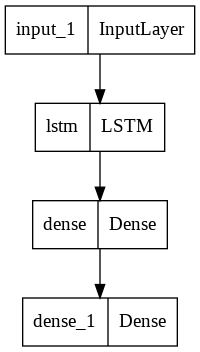

In [38]:
tf.keras.utils.plot_model(model)

In [16]:
model.compile(loss = tf.keras.losses.Huber(), optimizer = Adam(learning_rate=0.01), metrics = [RootMeanSquaredError()])

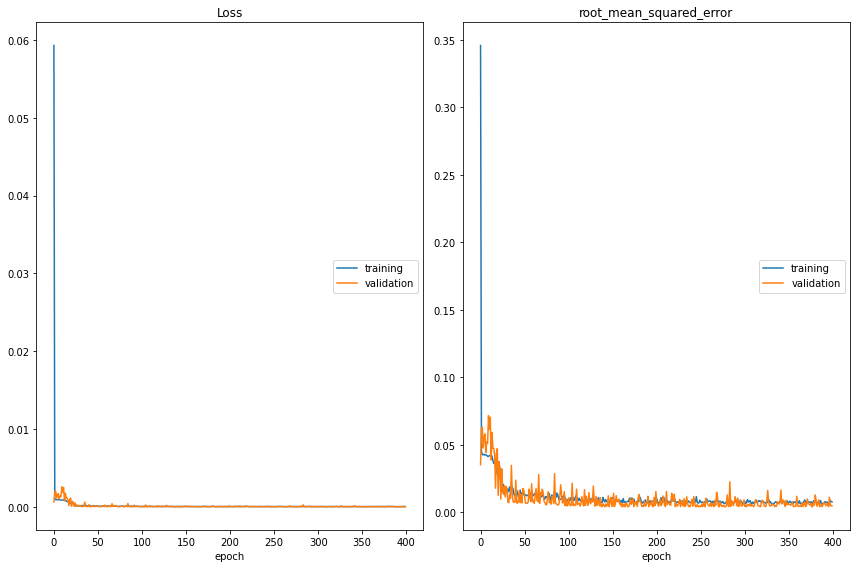

Loss
	training         	 (min:    0.000, max:    0.059, cur:    0.000)
	validation       	 (min:    0.000, max:    0.003, cur:    0.000)
root_mean_squared_error
	training         	 (min:    0.006, max:    0.346, cur:    0.008)
	validation       	 (min:    0.004, max:    0.072, cur:    0.005)
49/49 [==============================] - 1s 17ms/step - loss: 3.0508e-05 - root_mean_squared_error: 0.0078 - val_loss: 1.1536e-05 - val_root_mean_squared_error: 0.0048


In [17]:
model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs = 400,callbacks=[PlotLossesKeras()])

In [18]:
train_pred = model.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_pred,'Actuals':y_train})

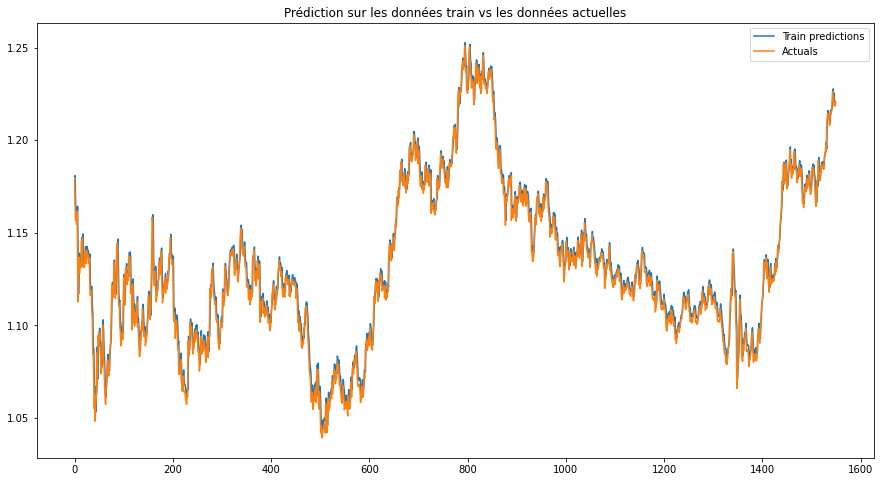

In [99]:
plt.figure(figsize=(15,8))
plt.plot(train_results['Train Predictions'])
plt.plot(train_results['Actuals'])
plt.title('Prédiction sur les données train vs les données actuelles')
plt.legend(['Train predictions', 'Actuals'])
plt.show()

In [20]:
val_predictions = model.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions,'Actuals':y_val})

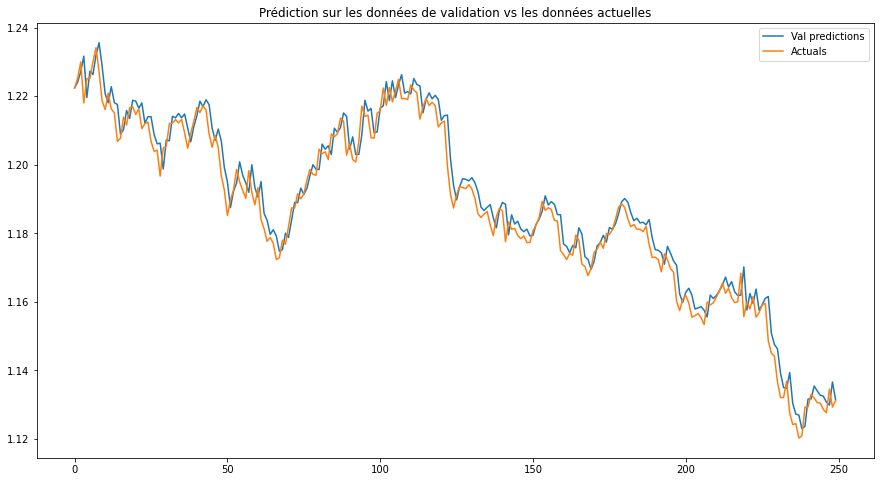

In [100]:
plt.figure(figsize=(15,8))
plt.plot(val_results['Val Predictions'])
plt.plot(val_results['Actuals'])
plt.title("Prédiction sur les données de validation vs les données actuelles")
plt.legend(['Val predictions', 'Actuals'])
plt.show()

Regardons par curiosité la moyenne du pourcentage d'erreurs des prédictions sur la série:

In [70]:
df_prediction = model.predict(X_test).flatten()
resultats = pd.DataFrame(data={'test Predictions':df_prediction,'Actuals':y_test})
error = list()
for val, predi in zip(resultats['Actuals'],resultats['test Predictions']):
  error.append(((predi * 100)/val)-100)
resultats['% Error'] = error
resultats.head()

,test Predictions,Actuals,% Error
0,1.133684,1.128541,0.455746
1,1.130709,1.126126,0.406918
2,1.128571,1.129076,-0.044714
3,1.131312,1.133414,-0.185427
4,1.135517,1.124354,0.992900


In [49]:
print("Pourcentage d'erreurs en moyenne: ",np.mean(resultats['% Error']), "%")

Pourcentage d'erreurs en moyenne:  0.37201842534233054 %


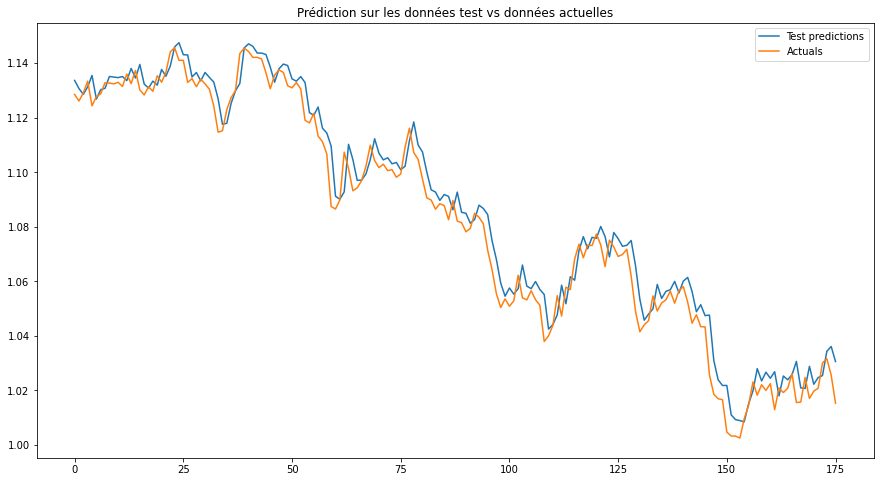

In [101]:
plt.figure(figsize=(15,8))
plt.plot(resultats['test Predictions'])
plt.plot(resultats['Actuals'])
plt.title('Prédiction sur les données test vs données actuelles')
plt.legend(['Test predictions', 'Actuals'])
plt.show()

Prédiction à +5 jours

In [74]:
x_input = np.array(X_test[-1:].flatten())
P = list(X_test[-1:].flatten())
for i in range(5):
  x_input = x_input.reshape((1, 10, 1))
  yhat = model.predict(x_input, verbose=0)
  P.append(yhat[0][0])
  x_input = np.array(P[i+1:]).flatten()

In [76]:
time = [i+1 for i in range(len(x_input[5:]))]

In [82]:
df_final = pd.DataFrame(resultats['test Predictions'].append(pd.Series(x_input[5:]), ignore_index=True))

In [83]:
df_final.columns = ['Test predictions']

In [85]:
y_test2 = list(y_test)
for i in range(5):
  y_test2.append(None)

In [86]:
df_final['Actuals'] = y_test2

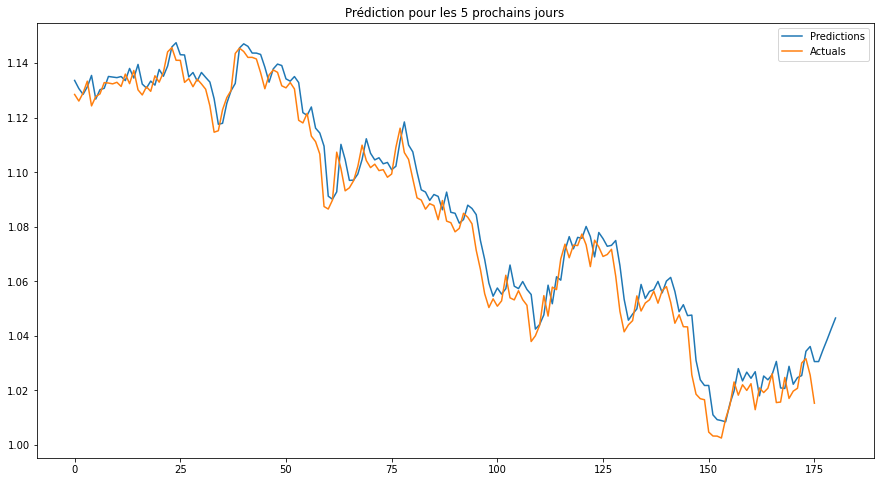

In [102]:
plt.figure(figsize=(15,8))
plt.plot(df_final['Test predictions'])
plt.plot(df_final['Actuals'])
plt.title("Prédiction pour les 5 prochains jours")
plt.legend(['Predictions', 'Actuals'])
plt.show()